In [32]:
import numpy as np
import pandas as pd
from predict_epitope.constant import LETTER_TO_IDX, IDX_TO_LETTER
import torch
from torch.nn.utils.rnn import pad_sequence
from predict_epitope.utils import convert_aa_to_int, pad_int_to_int_aa_seq, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,roc_auc_score

## Goal of this note book
This notebook is trying to apply a simple bidirectional-LSTM on peptide sequence in the bcell training set to see
how much accuracy one could achieve to predict the binding status. Given the **super imbalanced dataset**, sample with replacement according to the sample weight was use to ensure equal pos and neg class. 

One could play with it by changing the following settings:
- batch_size
- learning rate
- number of epoch
- dims of layers
- whether 1 or 2 FC layer after bi-LSTM is better 
- optimizer (this was not tested)

## Challenges of achieving good accuracy

- imbalanced dataset: 2926 for one class and 7864 for the other - this will cause the training always want to predict the majority class
- the imbalanced dataset issue can be solved by over-sampling minority class and under-sampling major class, however, the result of this is that the training accuracy is not increasing over epochs


In [33]:
bcell_train = pd.read_csv("../data/bcell_train.csv")
bcell_val = pd.read_csv("../data/bcell_val.csv")
print(bcell_train.shape)
print(bcell_val.shape)

(10586, 21)
(2117, 21)


In [34]:
bcell_train.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,...,hydrophobicity,stability,target,set_outcome,peptide_length,protein_length,extracted_peptide_seq,correct_start_pos,correct_end_pos,len_extracted_peptide_seq
0,P43261,MITHGCYTRTRHKHKLKKTLIMLSAGLGLFFYVNQNSFANGENYFK...,657,668,KASITEIKADKT,0.903,1.475,0.981,3.333,8.679749,...,-0.384797,31.507527,1,bcell_1,12,934,TKASITEIKADKTTA,656,668,15
1,P14916,MKLTPKELDKLMLHYAGELAKKRKEKGIKLNYVEAVALISAHIMEE...,70,78,VMDGVASMI,0.864,0.080,1.043,0.056,8.457703,...,-0.447479,19.310084,0,bcell_0,9,238,PDDVMDGVASMIHEV,69,78,15
2,P03227,MQGAQTSEDNLGSQSQPGPCGYIYFYPLATYPLREVATLGTGYAGH...,666,680,LAIDKGVLTAKEAKV,0.825,0.262,1.060,1.220,6.499573,...,-0.169681,45.118218,0,bcell_0,15,1128,LAIDKGVLTAKEAKV,665,680,15
3,P13423,MKKRKVLIPLMALSTILVSSTGNLEVIQAEVKQENRLLNESESSSQ...,423,432,IKAKENQLSQ,0.943,1.419,0.999,2.960,5.877991,...,-0.600131,31.614529,0,bcell_0,10,764,ATIKAKENQLSQILA,422,432,15
4,P08621,MTQFLPPNLLALFAPRDPIPYLPPLEKLPHEKHHNQPYCGIAPYIR...,105,114,LFVARVNYDT,0.892,0.046,1.076,0.080,9.940857,...,-1.839817,79.509611,0,bcell_0,10,437,KTLFVARVNYDTTES,104,114,15


#### limit the peptide to len 15 only and convert peptide strings to integer
Also tried padding the shorter peptide with 20 to make them length of 28 for each, but it didn't improve it from prediction monoclass

In [35]:
bcell_train['extracted_peptide_seq'] = bcell_train['extracted_peptide_seq'].apply(convert_aa_to_int)
bcell_train['extracted_peptide_seq'] = bcell_train['extracted_peptide_seq'].apply(pad_int_to_int_aa_seq, args=(15,))

bcell_val['extracted_peptide_seq'] = bcell_val['extracted_peptide_seq'].apply(convert_aa_to_int)
bcell_val['extracted_peptide_seq'] = bcell_val['extracted_peptide_seq'].apply(pad_int_to_int_aa_seq, args=(15,))

# confirm the length is 28 for each
print(np.unique(bcell_train['extracted_peptide_seq'].apply(len)))
print(np.unique(bcell_val['extracted_peptide_seq'].apply(len)))

[15]
[15]


In [36]:
# format validation X and y since validation data doesn't use dataloader and it should always be the same 
val_padded_peptide_in = torch.from_numpy(np.array(bcell_val['extracted_peptide_seq'].to_list())).type(torch.LongTensor)
val_true_target = torch.from_numpy(np.array(bcell_val['target'].to_list())).type(torch.FloatTensor).reshape((len(val_padded_peptide_in),1))
print(val_padded_peptide_in.shape, val_true_target.shape)

torch.Size([2117, 15]) torch.Size([2117, 1])


In [37]:
torch.from_numpy(np.array(bcell_val['extracted_peptide_seq'].to_list())).type(torch.LongTensor)

tensor([[19,  1,  5,  ..., 12, 17,  4],
        [ 9, 15,  5,  ..., 17, 17, 10],
        [ 5, 16, 12,  ..., 19,  5, 15],
        ...,
        [ 7,  5, 11,  ...,  6,  9,  9],
        [17, 14,  4,  ...,  4, 15,  7],
        [ 5, 18,  7,  ...,  0, 15, 19]])

In [38]:
torch.from_numpy(np.array(bcell_val['extracted_peptide_seq'].to_list()))

tensor([[19,  1,  5,  ..., 12, 17,  4],
        [ 9, 15,  5,  ..., 17, 17, 10],
        [ 5, 16, 12,  ..., 19,  5, 15],
        ...,
        [ 7,  5, 11,  ...,  6,  9,  9],
        [17, 14,  4,  ...,  4, 15,  7],
        [ 5, 18,  7,  ...,  0, 15, 19]])

#### Define hyperparameters
Things that would **REALLY** affect training speed and training accuracy
- Batch size
- Learning rate
- Number of epochs

In [39]:
EMBEDDING_DIM = 64
LSTM_HIDDEN_DIM = 32
FC_HIDDEN_DIM = 16
BATCH_SIZE = 256
LEARNING_RATE = 0.0005
EPOCH = 600

#### feed in the validation set instead of the training set to see if the model is able to predict two classes

In [40]:
# given the imbalanced dataset, use sampler to oversample the minority class, under sample positve class with replacement
# taken from https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/10
class_sample_count = np.array([len(np.where(bcell_train['target'].values==t)[0]) for t in np.unique(bcell_train['target'].values)]) 
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in bcell_train['target'].values])
samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

params = {'batch_size': BATCH_SIZE,
          'shuffle': True,#False,# sampler option is mutually exclusive with shuffle 
          'num_workers': 1}
training_set = Dataset(bcell_val['extracted_peptide_seq'].values, bcell_val['target'].values) ####**************
training_generator = torch.utils.data.DataLoader(training_set, **params,drop_last=True)#, sampler = sampler) # drop_last=True drop the last n samples that is no multiple of batch_size
num_sample_omitted = len(bcell_train['peptide_seq'])%params["batch_size"]


print(f"the number of sample to be omitted is {num_sample_omitted} ")

the number of sample to be omitted is 90 


In [41]:
(f"there are {bcell_val['target'].values.tolist().count(1)} 1 class and {bcell_val['target'].values.tolist().count(0)} 1 class")

'there are 568 1 class and 1549 1 class'

#### Confirm the shape of training data and training label

In [42]:
X,y = next(iter(training_generator))  
#print(X)
print(f"type of X from training_generator is {type(X)}")
X= torch.stack(X).T.type(torch.LongTensor) # longtensor is integer, default is float
print(X)
print(X.shape)
#print(y)

type of X from training_generator is <class 'list'>
tensor([[ 4,  8,  9,  ..., 12, 16, 19],
        [15,  2, 17,  ..., 12, 17, 17],
        [ 3,  0,  9,  ..., 16, 18,  6],
        ...,
        [ 6, 11,  9,  ...,  5, 11, 11],
        [15, 14, 15,  ..., 16,  4,  8],
        [ 9, 14, 14,  ..., 16, 15,  1]])
torch.Size([256, 15])


#### bidirectional LSTM https://towardsdatascience.com/text-generation-with-bi-lstm-in-pytorch-5fda6e7cc22c

In [43]:
# code similar to https://github.com/pytorch/tutorials/blob/master/beginner_source/nlp/sequence_models_tutorial.py
class BiDirLSTM(torch.nn.Module):
    def __init__(self, embedding_dim, lstm_hidden_dim,fc_hidden_dim, AA_vocab_len, target_size):
        super(BiDirLSTM, self).__init__()
        self.embedding_dim = embedding_dim
        # convert each unique AA represented by numeric form into embedding
        self.word_embeddings = torch.nn.Embedding(AA_vocab_len, embedding_dim)
    

        # turn on batch_first = T will make the first dim of input to be batch size, which is what we want here
        self.lstm = torch.nn.LSTM(embedding_dim, lstm_hidden_dim,batch_first=True, bidirectional=True) #batch_first=True,

        # The linear layer that maps from hidden state space to tag space
        # given it is bidirectional LSTM, the input dim will be twice as the previous single dir dim
        self.fc1 = torch.nn.Linear(lstm_hidden_dim*2, fc_hidden_dim)
        self.fc2 = torch.nn.Linear(fc_hidden_dim, target_size)   # here it use to be torch.nn.Linear
        #self.fc1 = torch.nn.Linear(lstm_hidden_dim*2, target_size)
        
    def forward(self, padded_peptide_seq):
        # h and c definition is commented out since when tried they require the input to have 3 dimensions, while I only have 2
        #h = torch.zeros((2, padded_peptide_seq.shape[0], self.embedding_dim)) #padded_peptide_seq.shape[0] is the batch size
        #c = torch.zeros((2, padded_peptide_seq.shape[0], self.embedding_dim)) #
        
        #print(h.shape)
        #print(c.shape)

        # Initialization fo hidden and cell states
        #torch.nn.init.xavier_normal_(h) #****
        #torch.nn.init.xavier_normal_(c) #****

         #this needed to be (1, 64)
            
        embeds = self.word_embeddings(padded_peptide_seq)
        # expect to be (batch_size, seq_len, input_size), seq_len is padded_len, batch is batch, input_size is the embedding for each AA. 
        #If embedding and other features of an AA is passed in, input_size = (embedding_size +feature_size)
        #print(f"embedding dim is {embeds.shape}") 
        lstm_out, (h_n, c_n) = self.lstm(embeds)
        #lstm_out, (h_n, c_n) = self.lstm(embeds, (h,c)) ****
        out = torch.relu_(self.fc1(lstm_out[:,-1,:]))
        out = torch.sigmoid(self.fc2(out))
        #out = torch.sigmoid(self.fc1(lstm_out[:,-1,:]))
        
        return out
        

In [44]:
#EPOCH =100
#LEARNING_RATE = 0.00001

In [45]:
model = BiDirLSTM(EMBEDDING_DIM,LSTM_HIDDEN_DIM, FC_HIDDEN_DIM, len(LETTER_TO_IDX)+1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

#### Start training

1990 127
average loss in epoch 0 is 0.684, average f1 is 0.635, average auc is 0.506
1992 125
average loss in epoch 1 is 0.684, average f1 is 0.637, average auc is 0.509
1994 123
average loss in epoch 2 is 0.683, average f1 is 0.642, average auc is 0.512
1995 122
average loss in epoch 3 is 0.683, average f1 is 0.64, average auc is 0.511
1996 121
average loss in epoch 4 is 0.683, average f1 is 0.64, average auc is 0.51
1997 120
average loss in epoch 5 is 0.683, average f1 is 0.633, average auc is 0.508
1998 119
average loss in epoch 6 is 0.682, average f1 is 0.637, average auc is 0.51
2003 114
average loss in epoch 7 is 0.682, average f1 is 0.637, average auc is 0.511
2007 110
average loss in epoch 8 is 0.682, average f1 is 0.637, average auc is 0.511
2009 108
average loss in epoch 9 is 0.682, average f1 is 0.636, average auc is 0.512
2011 106
average loss in epoch 10 is 0.681, average f1 is 0.64, average auc is 0.51
2014 103
average loss in epoch 11 is 0.681, average f1 is 0.642, avera

2117 0
average loss in epoch 99 is 0.664, average f1 is 0.619, average auc is 0.5
2117 0
average loss in epoch 100 is 0.664, average f1 is 0.616, average auc is 0.5
2117 0
average loss in epoch 101 is 0.663, average f1 is 0.619, average auc is 0.5
2117 0
average loss in epoch 102 is 0.663, average f1 is 0.623, average auc is 0.5
2117 0
average loss in epoch 103 is 0.663, average f1 is 0.615, average auc is 0.5
2117 0
average loss in epoch 104 is 0.663, average f1 is 0.62, average auc is 0.5
2117 0
average loss in epoch 105 is 0.663, average f1 is 0.619, average auc is 0.5
2117 0
average loss in epoch 106 is 0.662, average f1 is 0.621, average auc is 0.5
2117 0
average loss in epoch 107 is 0.662, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 108 is 0.662, average f1 is 0.616, average auc is 0.5
2117 0
average loss in epoch 109 is 0.662, average f1 is 0.62, average auc is 0.5
2117 0
average loss in epoch 110 is 0.662, average f1 is 0.618, average auc is 0.5
2117 0


2117 0
average loss in epoch 199 is 0.647, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 200 is 0.647, average f1 is 0.619, average auc is 0.5
2117 0
average loss in epoch 201 is 0.647, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 202 is 0.648, average f1 is 0.614, average auc is 0.5
2117 0
average loss in epoch 203 is 0.647, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 204 is 0.647, average f1 is 0.616, average auc is 0.5
2117 0
average loss in epoch 205 is 0.647, average f1 is 0.619, average auc is 0.5
2117 0
average loss in epoch 206 is 0.647, average f1 is 0.615, average auc is 0.5
2117 0
average loss in epoch 207 is 0.647, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 208 is 0.646, average f1 is 0.62, average auc is 0.5
2117 0
average loss in epoch 209 is 0.647, average f1 is 0.616, average auc is 0.5
2117 0
average loss in epoch 210 is 0.646, average f1 is 0.62, average auc is 0.5
2117 0

2117 0
average loss in epoch 299 is 0.633, average f1 is 0.622, average auc is 0.5
2117 0
average loss in epoch 300 is 0.633, average f1 is 0.621, average auc is 0.5
2117 0
average loss in epoch 301 is 0.634, average f1 is 0.62, average auc is 0.5
2117 0
average loss in epoch 302 is 0.634, average f1 is 0.617, average auc is 0.5
2117 0
average loss in epoch 303 is 0.634, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 304 is 0.634, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 305 is 0.634, average f1 is 0.617, average auc is 0.5
2117 0
average loss in epoch 306 is 0.633, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 307 is 0.634, average f1 is 0.616, average auc is 0.5
2117 0
average loss in epoch 308 is 0.633, average f1 is 0.619, average auc is 0.5
2117 0
average loss in epoch 309 is 0.633, average f1 is 0.621, average auc is 0.5
2117 0
average loss in epoch 310 is 0.633, average f1 is 0.616, average auc is 0.5
2117 

2117 0
average loss in epoch 399 is 0.623, average f1 is 0.621, average auc is 0.5
2117 0
average loss in epoch 400 is 0.623, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 401 is 0.624, average f1 is 0.614, average auc is 0.5
2117 0
average loss in epoch 402 is 0.622, average f1 is 0.623, average auc is 0.5
2117 0
average loss in epoch 403 is 0.622, average f1 is 0.622, average auc is 0.5
2117 0
average loss in epoch 404 is 0.623, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 405 is 0.623, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 406 is 0.622, average f1 is 0.621, average auc is 0.5
2117 0
average loss in epoch 407 is 0.623, average f1 is 0.617, average auc is 0.5
2117 0
average loss in epoch 408 is 0.623, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 409 is 0.624, average f1 is 0.614, average auc is 0.5
2117 0
average loss in epoch 410 is 0.623, average f1 is 0.615, average auc is 0.5
2117

2117 0
average loss in epoch 498 is 0.615, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 499 is 0.614, average f1 is 0.621, average auc is 0.5
2117 0
average loss in epoch 500 is 0.614, average f1 is 0.62, average auc is 0.5
2117 0
average loss in epoch 501 is 0.615, average f1 is 0.616, average auc is 0.5
2117 0
average loss in epoch 502 is 0.615, average f1 is 0.617, average auc is 0.5
2117 0
average loss in epoch 503 is 0.616, average f1 is 0.616, average auc is 0.5
2117 0
average loss in epoch 504 is 0.614, average f1 is 0.619, average auc is 0.5
2117 0
average loss in epoch 505 is 0.615, average f1 is 0.616, average auc is 0.5
2117 0
average loss in epoch 506 is 0.613, average f1 is 0.621, average auc is 0.5
2117 0
average loss in epoch 507 is 0.614, average f1 is 0.619, average auc is 0.5
2117 0
average loss in epoch 508 is 0.615, average f1 is 0.616, average auc is 0.5
2117 0
average loss in epoch 509 is 0.614, average f1 is 0.62, average auc is 0.5
2117 0

2117 0
average loss in epoch 598 is 0.608, average f1 is 0.618, average auc is 0.5
2117 0
average loss in epoch 599 is 0.608, average f1 is 0.618, average auc is 0.5


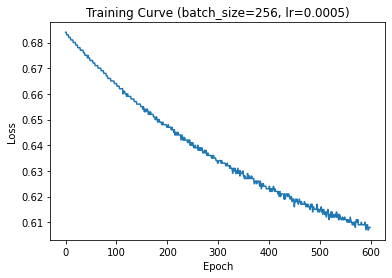

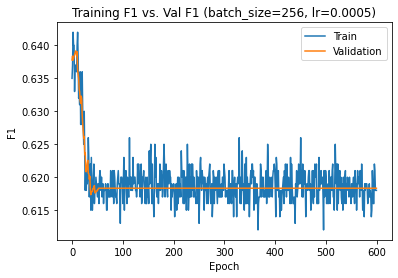

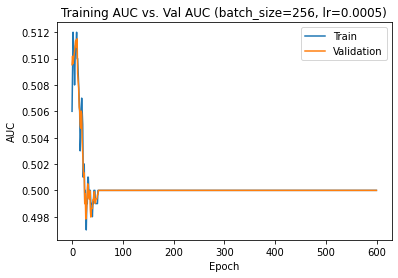

In [46]:
# define model


# loop through epochs 
average_loss = []
train_f1_list = []
train_auc_list = []

val_f1_list = []
val_auc_list = []


for epoch in range(EPOCH):  # again, normally you would NOT do 300 epochs, it is toy data
    total_loss = 0.0
    total_f1 = 0.0
    total_auc = 0.0
    batch_number = 0
    for padded_peptide, target in training_generator:
        # Step 0: updating the num of batch 
        batch_number +=1
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        # torch.stack convert input to tensor, and transpose it to (batch_size, padded_len), torch.LongTensor convert to intabs
        padded_peptide_in = torch.stack(padded_peptide).T.type(torch.LongTensor)
        true_target = target.type(torch.FloatTensor).reshape((len(padded_peptide_in),1)) #torch.FloatTensor is the default type
        
        #print(f"true target shape is {true_target.shape}")
        
        # Step 3. Run our forward pass.
        pred_target = model(padded_peptide_in)
        #print(f"pred target shape is {pred_target.shape}")
        #print(padded_peptide_in)
        
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = torch.nn.functional.binary_cross_entropy(pred_target, true_target)
        
        #print(f"target shapes are {pred_target.shape, true_target.shape}")
        # Step 5. compute accuracy
        pred_binary = (pred_target > 0.5).type(torch.FloatTensor)
        
        f1 = f1_score(true_target, pred_binary, average = 'weighted')
        auc = roc_auc_score(true_target, pred_binary, average = 'weighted')
        
        loss.backward()
        #optimizer.step is performs a parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule.
        optimizer.step()
        #The item() method extracts the loss’s value as a Python float.
        total_loss +=loss.item()
        total_f1 += f1
        total_auc += auc
        
    # Step 6. for each epoch compute loss, accuracy in training set and compute accuracy on validation set
    # on train set
    average_loss_each_epoch = round(total_loss/batch_number,3)
    average_f1 = round(total_f1/batch_number,3)
    train_f1_list.append(average_f1)
    average_auc = round(total_auc/batch_number,3)
    train_auc_list.append(average_auc)
    average_loss.append(average_loss_each_epoch)
    
    # on val set
    pred_val_target = model(val_padded_peptide_in)
    val_pred_binary = (pred_val_target > 0.5).type(torch.FloatTensor)
    #print(val_pred_binary.tolist())
    print(val_pred_binary.tolist().count([0.0]), val_pred_binary.tolist().count([1.0]))
    
    val_f1 = f1_score(val_true_target, val_pred_binary, average = 'weighted')
    val_auc = roc_auc_score(val_true_target, val_pred_binary, average = 'weighted')

    val_f1_list.append(val_f1)
    val_auc_list.append(val_auc)
    
    print(f"average loss in epoch {epoch} is {average_loss[-1]}, average f1 is {average_f1}, average auc is {average_auc}")


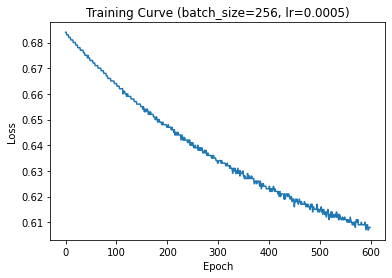

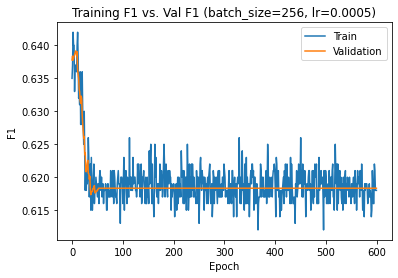

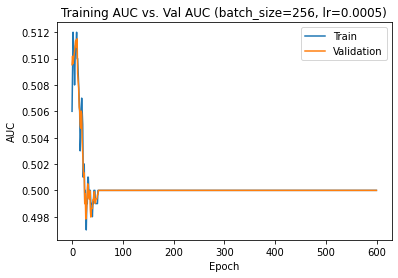

In [47]:
# Step 7. plot the training loss and accuracy per epoch, https://www.cs.toronto.edu/~lczhang/360/lec/w02/training.html
# training loss
plt.plot(range(EPOCH), average_loss)
plt.title(f"Training Curve (batch_size={BATCH_SIZE}, lr={LEARNING_RATE})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# training f1 vs. val f1
plt.plot(range(EPOCH), train_f1_list, label = "Train")
plt.plot(range(EPOCH), val_f1_list, label = "Validation")
plt.title(f"Training F1 vs. Val F1 (batch_size={BATCH_SIZE}, lr={LEARNING_RATE})")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.legend(loc='best')
plt.show()

# training auc vs. val auc
plt.plot(range(EPOCH), train_auc_list, label = "Train")
plt.plot(range(EPOCH), val_auc_list, label = "Validation")
plt.title(f"Training AUC vs. Val AUC (batch_size={BATCH_SIZE}, lr={LEARNING_RATE})")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend(loc='best')
plt.show()

#### Save results to file

In [ ]:
#for padded_peptide, target in training_generator:
# Step 0: updating the num of batch 
#batch_number +=1
# Step 1. Remember that Pytorch accumulates gradients.
# We need to clear them out before each instance
model.zero_grad()

# Step 2. Get our inputs ready for the network, that is, turn them into
# Tensors of word indices.
# torch.stack convert input to tensor, and transpose it to (batch_size, padded_len), torch.LongTensor convert to intabs
padded_peptide_in = torch.stack(padded_peptide).T.type(torch.LongTensor)

true_target = target.type(torch.FloatTensor).reshape((len(padded_peptide_in),1)) #torch.FloatTensor is the default type
print(padded_peptide_in.shape, true_target.shape)
#print(f"true target shape is {true_target.shape}")

# Step 3. Run our forward pass.
pred_target = model(padded_peptide_in)
#print(f"pred target shape is {pred_target.shape}")
#print(padded_peptide_in)

# Step 4. Compute the loss, gradients, and update the parameters by
#  calling optimizer.step()
loss = torch.nn.functional.binary_cross_entropy(pred_target, true_target)

print(f"target shapes are {pred_target.shape, true_target.shape}")
# Step 5. compute accuracy
pred_binary = (pred_target > 0.5).type(torch.FloatTensor)
